# [7] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle



# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

/usr/lib/python3/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
print(filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape


(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [10]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [11]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'all', 'no', 'because', 'now', 'very', "she's", 'too', 'be', 'nor', 'won', 'ma', 'does', 'on', 'they', 'such', 'myself', "you'd", 'had', 'by', 'aren', "isn't", 'shouldn', 'y', 'these', 'itself', 'me', 'the', "you've", 'needn', 'our', 'against', 'out', 'who', 'not', 'as', 'over', 'doesn', 'just', 'about', 'is', 'during', 'again', "haven't", "shouldn't", 'in', 'haven', 't', "didn't", 'his', 'an', 'and', 'why', 'him', 'only', 'mustn', "hadn't", "shan't", 'how', 'some', 's', 'down', "mustn't", 'there', 'shan', "that'll", 'theirs', 'were', 'll', 'my', 'was', 'their', 'am', 'what', 'with', 'your', 'before', "it's", "you'll", 'while', "don't", 'from', "doesn't", 'than', 'isn', 'for', 'where', 'few', 'being', 'whom', "aren't", 'both', 'yours', 'so', 'yourselves', 'or', 'ain', 'you', 'up', 'but', 'himself', 'when', 'below', 'of', 'this', 'been', 'wouldn', 'ours', 'themselves', 'that', 'doing', 'until', 'under', 'those', 'did', "mightn't", 've', 'she', 'd', 'hers', 'hasn', 'once', 'more', 'afte

In [12]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [13]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [14]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

# [7.2.2] Bag of Words (BoW)

In [37]:
final.shape

(364171, 11)

In [38]:
# Sorting data based on time
final["Time"] = pd.to_datetime(final["Time"], unit = "s")
final = final.sort_values(by = "Time")


In [39]:
# Considering 250K data samples 

final_60k = final[:250000]

In [40]:
# 60k data which will use to train model after vectorization

X = final_60k["CleanedText"]
print("shape of X:", X.shape)

shape of X: (250000,)


In [41]:
y = final_60k["Score"]
print("shape of y:", y.shape)

shape of y: (250000,)


In [42]:
from sklearn.naive_bayes import MultinomialNB

In [21]:
# Function to compute alpha value

def naive_bayes(X_train, y_train):
    
    alpha_values = np.arange(1, 500, 0.5)
        

    # empty list that will hold cv scores
    cv_scores = []

    # perform cross validation
    for alpha in alpha_values:
        mnb = MultinomialNB(alpha = alpha)
        scores = cross_val_score(mnb, X_train, y_train, cv = 2, scoring = 'accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best alpha
    optimal_alpha = alpha_values[MSE.index(min(MSE))]
    print('\nThe optimal number of alpha is %d.' % optimal_alpha)

    # plot misclassification error vs alpha
    plt.plot(alpha_values, MSE, marker = '*') 

    #for xy in zip(alpha_values, np.round(MSE,3)):
        #plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title("Misclassification Error vs alpha")
    plt.xlabel('value of alpha')
    plt.ylabel('Misclassification Error')
    plt.show()

    #print("the misclassification error for each value of alpha is : ", np.round(MSE,3))
    return optimal_alpha

In [47]:
# split data into train and test where 70% data used to train model and 30% for test

from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, x_test.shape)

(175000,) (175000,) (75000,)


In [48]:
# Training using CountVectorizer

from sklearn.feature_extraction.text import CountVectorizer 

abc = CountVectorizer()
X_train = abc.fit_transform(X_train)
X_train

<175000x49278 sparse matrix of type '<class 'numpy.int64'>'
	with 5477408 stored elements in Compressed Sparse Row format>

In [26]:
X_train

<175000x49379 sparse matrix of type '<class 'numpy.int64'>'
	with 5380116 stored elements in Compressed Sparse Row format>

In [49]:
# Test Vectorizor

x_test = abc.transform(x_test)
x_test

<75000x49278 sparse matrix of type '<class 'numpy.int64'>'
	with 2326743 stored elements in Compressed Sparse Row format>


The optimal number of alpha is 1.


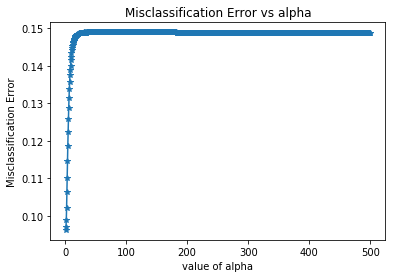

1.0

In [32]:
# To choose optimal_alpha using cross validation

optimal_alpha_bow = naive_bayes(X_train, y_train)
optimal_alpha_bow

In [33]:
# instantiate learning model alpha = optimal_alpha
nb_optimal =  MultinomialNB(alpha = optimal_alpha_bow)

# fitting the model
nb_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)

# predict the response
pred = nb_optimal.predict(x_test)

In [36]:
# Error on train data
train_err_bow = 1-train_acc_bow
print("Train Error %f%%" % (train_err_bow))

Train Error 0.085429%


In [35]:
# Accuracy on train data
train_acc_bow = nb_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_bow)

Train accuracy 0.9145714285714286


In [37]:
# evaluate accuracy on test data

acc_bow = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the naive bayes classifier for alpha = %d is %f%%' % (optimal_alpha_bow, acc_bow))


The accuracy of the naive bayes classifier for alpha = 1 is 90.729333%


In [38]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

   negative       0.70      0.66      0.68     11173
   positive       0.94      0.95      0.95     63827

avg / total       0.91      0.91      0.91     75000



In [39]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[ 7389,  3784],
       [ 3169, 60658]])

In [36]:
# Function to plot Confusion_Matrix

def Confusion_Matrix(q,w):
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Confusiion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

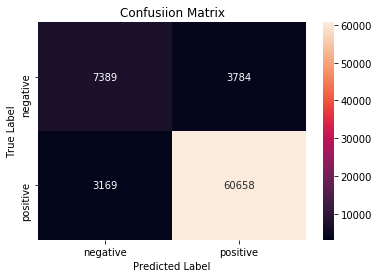

In [41]:
Confusion_Matrix(y_test, pred)

In [38]:
pred_proba = nb_optimal.predict_proba(x_test)
words = np.take(abc.get_feature_names(), pred_proba.argmax(axis=1))
print(words)

['aaa' 'aaa' 'aaa' ... 'aaa' 'aaa' 'aa']


In [53]:
Feature_imp =  nb_optimal.predict_log_proba(x_test)
Feature_imp

array([[-7.29676626e+00, -6.77956590e-04],
       [-1.21355117e+01, -5.36556422e-06],
       [-1.94065729e+01, -3.73097464e-09],
       ...,
       [-4.41059652e-02, -3.14313217e+00],
       [-6.68186718e+00, -1.25422161e-03],
       [-8.14872518e+01,  0.00000000e+00]])

In [35]:
# Defining function for important Features based on classess

def important_features(vectorizer,classifier,n=20):
    class_labels = classifier.classes_
    feature_names =vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.feature_count_[0], feature_names),reverse=True)[:n]
    topn_class2 = sorted(zip(classifier.feature_count_[1], feature_names),reverse=True)[:n]
    print("Important words in negative reviews")
    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)
    print("-----------------------------------------")
    print("Important words in positive reviews")
    for coef, feat in topn_class2:
        print(class_labels[1], coef, feat)

In [65]:
important_features(abc, nb_optimal , n=20)

Important words in negative reviews
negative 15885.0 tast
negative 14745.0 like
negative 12279.0 product
negative 9521.0 one
negative 9015.0 flavor
negative 8196.0 tri
negative 8025.0 would
negative 6974.0 good
negative 6721.0 use
negative 6678.0 coffe
negative 6196.0 get
negative 6143.0 buy
negative 5856.0 order
negative 5756.0 food
negative 5548.0 tea
negative 5425.0 dont
negative 5047.0 box
negative 5001.0 even
negative 4854.0 amazon
negative 4523.0 make
-----------------------------------------
Important words in positive reviews
positive 66216.0 like
positive 61646.0 tast
positive 53823.0 good
positive 52623.0 flavor
positive 51436.0 love
positive 50410.0 great
positive 49263.0 use
positive 46478.0 one
positive 42791.0 product
positive 42215.0 tea
positive 41378.0 tri
positive 36828.0 make
positive 36677.0 coffe
positive 34642.0 get
positive 30609.0 food
positive 26439.0 time
positive 25884.0 would
positive 25856.0 buy
positive 25549.0 amazon
positive 25496.0 eat


# [7.2.5] TF-IDF

In [15]:
final.shape

(364171, 11)

In [16]:
# Sorting data based on time
final["Time"] = pd.to_datetime(final["Time"], unit = "s")
final = final.sort_values(by = "Time")

In [17]:
final_60k = final[:250000]

In [18]:
# Assigning data to X

X = final_60k["CleanedText"]

# Target/class-label

y = final_60k["Score"]

In [19]:
# Spliting the data into train and test such that 70% data will be used to train model and 30% for test purpose.

X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)


(175000,) (75000,) (175000,) (75000,)


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer


tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train = tf_idf_vect.fit_transform(X_train)
X_train

<175000x1810531 sparse matrix of type '<class 'numpy.float64'>'
	with 11818086 stored elements in Compressed Sparse Row format>

In [21]:
# Convert test text data to its vectorizor

x_test = tf_idf_vect.transform(x_test)
x_test.shape

(75000, 1810531)


The optimal number of alpha is 1.


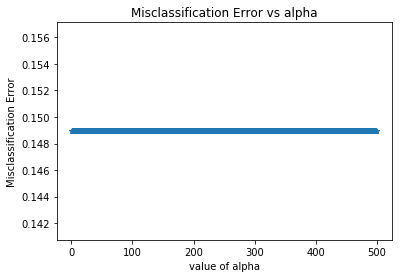

1.0

In [73]:
# choosing optimal alpha value for tfidf

optimal_alpha_tfidf = naive_bayes(X_train, y_train)
optimal_alpha_tfidf

In [52]:
# instantiate learning model alpha = optimal_alpha
nb_optimal = MultinomialNB(alpha = 1)

# fitting the model
nb_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)
    
# predict the response
pred = nb_optimal.predict(x_test)

In [53]:
# Checking accuracy on train data

train_acc_tfidf = nb_optimal.score(X_train, y_train)
print("Accuracy on train data is", train_acc_tfidf)

Accuracy on train data is 0.8995942857142857


In [54]:
# Error on train data

train_err_tfidf = 1-train_acc_tfidf
print("Error on train data is", train_err_tfidf)

Error on train data is 0.10040571428571432


In [55]:
# evaluate accuracy

acc_tfidf = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the classifier for alpha = %d is %f%%' % (1, acc_tfidf))


The accuracy of the classifier for alpha = 1 is 89.397333%


In [56]:
from sklearn.metrics import f1_score

In [57]:
# evaluate accuracy

acc_tfidf = f1_score(y_test, pred , average = 'micro') * 100
print('\nThe accuracy of the classifier for alpha = %d is %f%%' % (1, acc_tfidf))


The accuracy of the classifier for alpha = 1 is 89.397333%


In [58]:
# To show main classification report

from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

   negative       0.83      0.36      0.50     11146
   positive       0.90      0.99      0.94     63854

avg / total       0.89      0.89      0.88     75000



In [59]:
cm = confusion_matrix(y_test, pred)
cm

array([[ 4040,  7106],
       [  846, 63008]])

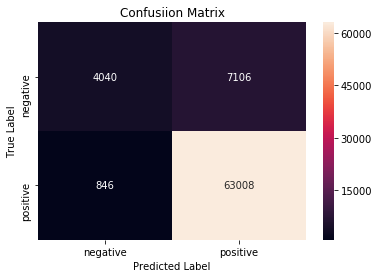

In [60]:
Confusion_Matrix(y_test, pred)

In [80]:
important_features(tf_idf_vect, nb_optimal , n=20)

Important words in negative reviews
negative 491.9262128393175 tast
negative 428.99898598993417 like
negative 406.4845172644873 product
negative 305.04167078281887 would
negative 298.4000726475584 coffe
negative 295.9670947563696 flavor
negative 291.3593643013266 one
negative 259.4020024653388 tri
negative 257.20486536626225 buy
negative 256.9307107586661 order
negative 234.22505616917587 box
negative 232.69237948646045 tea
negative 218.2691175235152 good
negative 215.5041743724 disappoint
negative 212.9992195730509 dont
negative 210.83069339622887 get
negative 203.54771504753336 use
negative 196.03695937278448 even
negative 190.6881259100621 food
negative 184.30439712435472 bad
-----------------------------------------
Important words in positive reviews
positive 2094.8115024067292 great
positive 2074.129375088104 love
positive 1992.4556696466097 tea
positive 1977.9458002860358 tast
positive 1961.439201282885 like
positive 1951.9703932621192 good
positive 1838.7216963311505 flavor
pos

In [61]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Method", " Naive-bayes Algorithm with " ,  "Accuracy"]

x.add_row(["BOG", 'Hyperparameter aplha = 1 ',  '90.261333%'])
x.add_row(["TFIDF", 'Hyperparameter aplha = 1 ', ' 89.39733%'])

print(x)


+--------+------------------------------+------------+
| Method |  Naive-bayes Algorithm with  |  Accuracy  |
+--------+------------------------------+------------+
|  BOG   |  Hyperparameter aplha = 1    | 90.261333% |
| TFIDF  |  Hyperparameter aplha = 1    |  89.39733% |
+--------+------------------------------+------------+


# Observations : - 


###  All the above results with  of BOG, TFIDF techniques,  varys for different alpha for Naive-bayes algorithm. Out of all of , BOG  gives us highest accuracy of aprox 90%